### Convolution Autoencoder

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/d


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 取"正常"資料訓練模型

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train == 8]
x_test = x_test[y_test == 8]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [3]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

## 訓練模型 

In [4]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                verbose = 0,
                validation_data=(x_test, x_test))

## 產生預測結果

In [5]:
predictions = autoencoder.predict(x_test)

In [6]:
errors = []
for (image, recon) in zip(x_test, predictions):
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)

## 產生偏誤資料集

In [7]:
from keras.datasets import mnist
import numpy as np

(_, _) , (x_test2, y_test2) = mnist.load_data()

x_test2 = x_test2[y_test2 == 4]
x_test2 = x_test2.astype('float32') / 255.


In [8]:
x_test2 = np.reshape(x_test2, (len(x_test2), 28, 28, 1)) 
predictions2 = autoencoder.predict(x_test2)

In [9]:
errors2 = []
for (image, recon) in zip(x_test2, predictions2):
    mse = np.mean((image - recon) ** 2)
    errors2.append(mse)

## 評估誤差(Bias)與標準差(Standard Deviation)

In [10]:
import numpy as np
np_errors = np.array(errors)
np_errors.mean(), np_errors.std()

(0.021246152, 0.008117986)

In [11]:
np_errors2 = np.array(errors2)
np_errors2.mean(), np_errors2.std()

(0.043140437, 0.011333636)

In [12]:
error_ary = []
for rec in errors:
    dic = {}
    dic['error'] = rec
    dic['label'] = 0
    error_ary.append(dic)
    
for rec in errors2:
    dic = {}
    dic['error'] = rec
    dic['label'] = 1
    error_ary.append(dic)


## 建立誤差DataFrame

In [13]:
from sklearn.utils import shuffle
import pandas
error_df = pandas.DataFrame(error_ary)
error_df = shuffle(error_df)

In [18]:
error_df.head()

,error,label
567,0.024578,0
721,0.012923,0
170,0.022207,0
1874,0.053225,1
1763,0.036864,1


In [19]:
error_df.reset_index(inplace=True)
del error_df['index']

## 繪製重建誤差

In [20]:
groups = error_df.groupby('label')

Populating the interactive namespace from numpy and matplotlib


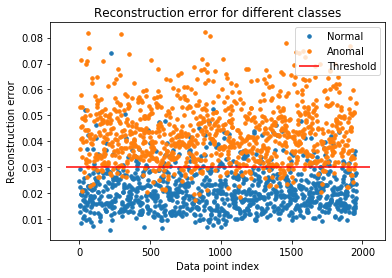

In [22]:
%pylab inline
threshold = 0.03
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.error, marker='o', ms=3.5, linestyle='',
            label= "Anomal" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [23]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

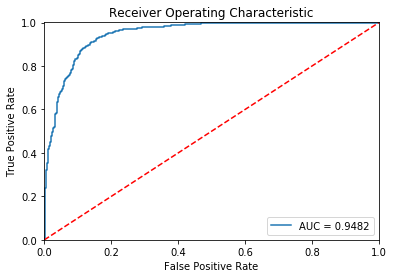

In [24]:
fpr, tpr, thresholds = roc_curve(error_df.label, error_df.error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
y_pred = [1 if e > threshold else 0 for e in error_df.error.values]
conf_matrix = confusion_matrix(error_df.label, y_pred)
conf_matrix

array([[847, 127],
       [103, 879]])